# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 9
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, April 7th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

This Homework is a continuation of Problem #1 from Homework 8.

Your answers to Problem #1 from HW8 should  give you a idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model in this Homework, which is much more technically involved.


## Problem #1: Modeling Your Understanding

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to Part A and B:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to Extra Credit:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.pdf">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*

### Part A: Modeling

When the value in "count" is low, the "mean" value can be very skewed.

Following the [SAT prep school example discussed in lab](https://am207.github.io/2018spring/wiki/gelmanschoolstheory.html) (and using your answers for HW 8 Problem #1), set up a Bayesian model(that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service, separately. That is, you will have a model for each restaurant and each aspect (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** what quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

### Part B: Analysis for Each restaurant

Use your model to produce estimates for $\theta_{jk}$'s. Pick a few restaurants, for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the same restaurants, for each aspect, generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  

The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.

The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.

The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 

The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.

We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Use these plots to discuss the statistical benefits of modeling each reviewer's opinion using your model from Part A, rather than approximating the reviewer opinion with the value in "mean".

Example of a shrinkage plot:
<img src="shrinkage.png">

Example of a probability shrinkage plot:
<img src="shrinkage_prob.png">

### Part C: Analysis Across Restaurants

Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. Discuss the statistical weakness of ranking by these scores.

(**Hint:** what is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? You've seen this question addressed a number of times in previous homeworks. This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)

### Extra Credit:

1. Propose a model addressing the weakness of your approach in Part C for the overall quality of food and service for each restaurant given the $\theta$'s. Combine your model for the overall quality with your model for the $\theta$'s. 
2. Implement and use this combined model to estimate the overall quality of food and service for each restaurant.

(Its perfectly ok to just propose and not implement, you'll just get less credit. But please atleast try part 1!)



### Name: Christopher Hase

In [215]:
import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
from pymc3 import summary

In [216]:
reviews = pd.read_csv('reviews_processed.csv')
reviews.head()

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


In [3]:
# getting 10 restaurants to analyze; mix of number of reviews
rest_reviews_asc = np.unique(reviews['rid'])[np.argsort(np.unique(reviews['rid'], return_counts=True)[1])]
rest_many_reviews = rest_reviews_asc[-3:]
rest_few_reviews = rest_reviews_asc[20:23]
rest_mid_reviews = rest_reviews_asc[5000:5004]
rest10 = np.concatenate([rest_many_reviews, rest_mid_reviews, rest_few_reviews])
rest10_df = reviews[reviews['rid'].isin(rest10)]

### Part A

In [275]:
# to get trace for a particular restaurant for a particular topic
def get_restaurant_topic_trace(df, rid, topic):
    
    # get subset of restaurants for topic/restaurant id combo
    subset_df = df[(df['rid'] == rid) & (df['topic'] == topic) & (df['count'] != 1)]
    
    # estimating the standard errors of ybar_jk from data
    se_ybar_jks = np.sqrt(subset_df['var'].values/subset_df['count'].values)
        
    with pm.Model() as reviewer_model:
        
        ### empirical bayes approach
        mu_k = pm.Normal('mu_k', mu=df[(df['rid']==rid) & (df['topic']==topic)]['mean'].mean(),\
                          sd=np.std(df[(df['rid']==rid) & (df['topic']==topic)]['mean'], ddof=1))
        
        tau_k = pm.HalfCauchy('tau_k', beta=1)
        
        nu_jks = pm.Normal('nu_jk', mu=0, sd=2, shape = len(subset_df))
        
        theta_jks = pm.Deterministic('theta_jk', mu_k + nu_jks * tau_k)
        
        ybar_jk = pm.Normal('ybar_jk_obs', mu=theta_jks, sd=se_ybar_jks,\
                            observed = subset_df['mean'].values)
        
        step = pm.step_methods.hmc.nuts.NUTS(target_accept = 0.95)
        restaurant_topic_trace = pm.sampling.sample(draws = 2100, step = step,\
                                                       init = 'advi', tuning = 10000000, chains = 1,\
                                                       compute_convergence_checks = False)

    return restaurant_topic_trace, len(subset_df)

### Part B

In [173]:
# estimating thetas for each restaurant for each topic
rids = np.unique(rest10_df['rid'].values)
topics = [0, 1]

for topic in topics:
    traces[topic] = {}
    for rid in rids:
        traces[topic][rid] = get_reviewer_restaurant_topic_trace(rest10_df, rid, topic)

Sequential sampling (1 chains in 1 job)
NUTS: [nu_jk, tau_k_log__, mu_k]
100%|██████████| 2600/2600 [00:36<00:00, 70.71it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.906575358939, but should be close to 0.95. Try to increase the number of tuning steps.
Sequential sampling (1 chains in 1 job)
NUTS: [nu_jk, tau_k_log__, mu_k]
100%|██████████| 2600/2600 [00:35<00:00, 72.25it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sequential sampling (1 chains in 1 job)
NUTS: [nu_jk, tau_k_log__, mu_k]
100%|██████████| 2600/2600 [00:23<00:00, 110.05it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sequential sampling (1 chains in 1 job)
NUTS: [nu_jk, tau_k_log__, mu_k]
100%|██████████| 2600/2600 [00:33<00:00, 77.44it/s]
Sequential sampling (1 chains in 1 job)
NUTS: [nu_jk, tau_k_log__, mu_k]
100%|██████████| 2600/2600 [

Traceplots and estimated posteriors for thetas, rid=z0t16bRro5x1hOZXzJ0NIw, topic=food


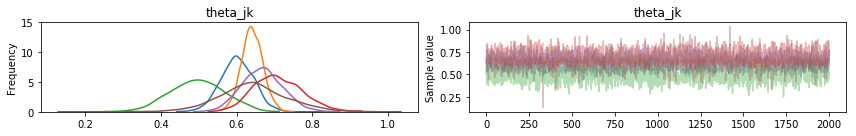


Traceplots and estimated posteriors for thetas, rid=z0t16bRro5x1hOZXzJ0NIw, topic=service


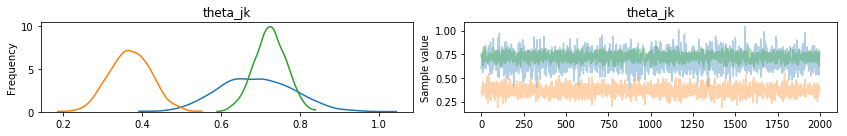


Traceplots and estimated posteriors for thetas, rid=4uGHPY-OpJN08CabtTAvNg, topic=food


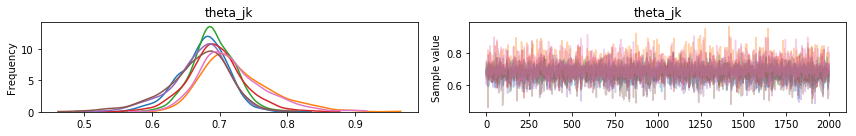


Traceplots and estimated posteriors for thetas, rid=4uGHPY-OpJN08CabtTAvNg, topic=service


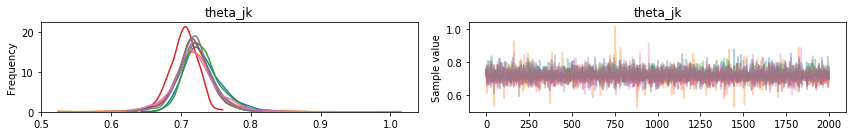

In [218]:
# traceplots and estimated posteriors for thetas
print('Traceplots and estimated posteriors for thetas, rid=' + rids[9] + ', topic=food')
pm.traceplot(traces[0][rids[9]][0][100:], varnames=['theta_jk'])
plt.show()
print()
print('Traceplots and estimated posteriors for thetas, rid=' + rids[9] + ', topic=service')
pm.traceplot(traces[1][rids[9]][0][100:], varnames=['theta_jk'])
plt.show()
print()
print('Traceplots and estimated posteriors for thetas, rid=' + rids[1] + ', topic=food')
pm.traceplot(traces[0][rids[1]][0][100:], varnames=['theta_jk'])
plt.show()
print()
print('Traceplots and estimated posteriors for thetas, rid=' + rids[1] + ', topic=service')
pm.traceplot(traces[1][rids[1]][0][100:], varnames=['theta_jk'])
plt.show()

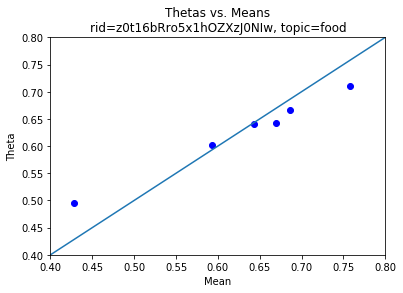

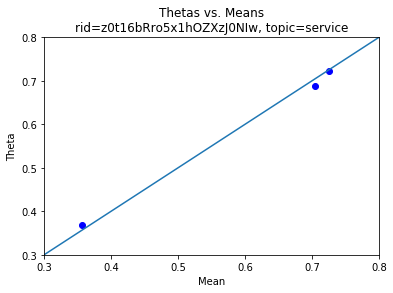

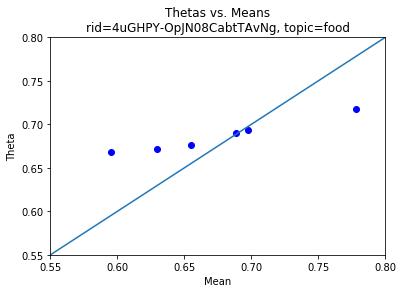

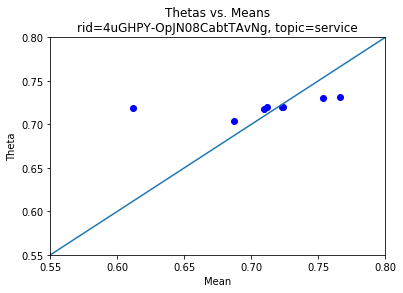

In [273]:
thetas = summary(traces[0][rids[9]][0][100:])[-traces[0][rids[9]][1]:]['mean'].values
means = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['mean'].values
plt.plot(means, thetas, 'bo')
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.title('Thetas vs. Means\nrid=' + rids[9] + ', topic=food')
plt.xlabel('Mean')
plt.ylabel('Theta')
plt.show()

thetas = summary(traces[1][rids[9]][0][100:])[-traces[1][rids[9]][1]:]['mean'].values
means = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['mean'].values
plt.plot(means, thetas, 'bo')
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.xlim([0.3, 0.8])
plt.ylim([0.3, 0.8])
plt.title('Thetas vs. Means\nrid=' + rids[9] + ', topic=service')
plt.xlabel('Mean')
plt.ylabel('Theta')
plt.show()

thetas = summary(traces[0][rids[1]][0][100:])[-traces[0][rids[1]][1]:]['mean'].values
means = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['mean'].values
plt.plot(means, thetas, 'bo')
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.xlim([0.55, 0.8])
plt.ylim([0.55, 0.8])
plt.title('Thetas vs. Means\nrid=' + rids[1] + ', topic=food')
plt.xlabel('Mean')
plt.ylabel('Theta')
plt.show()

thetas = summary(traces[1][rids[1]][0][100:])[-traces[1][rids[1]][1]:]['mean'].values
means = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['mean'].values
plt.plot(means, thetas, 'bo')
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.xlim([0.55, 0.8])
plt.ylim([0.55, 0.8])
plt.title('Thetas vs. Means\nrid=' + rids[1] + ', topic=service')
plt.xlabel('Mean')
plt.ylabel('Theta')
plt.show()

In [86]:
import itertools
import seaborn as sns
import scipy.special

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - scipy.special.erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    plt.figure(figsize=(7,5))
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            plt.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            plt.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        plt.yticks([])
        plt.xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    plt.figure(figsize=(7,5))
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            plt.plot([m, t],[p, peb],'o-', color=color, lw=1)
            plt.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
    return ax

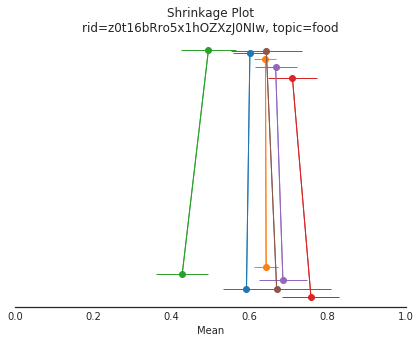

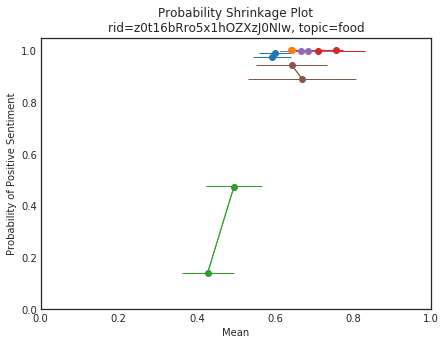

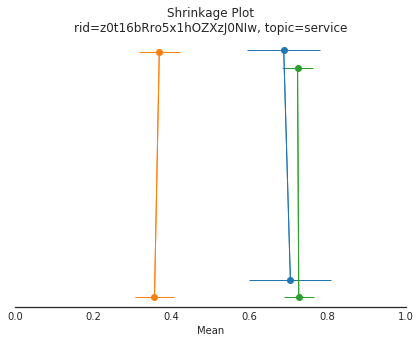

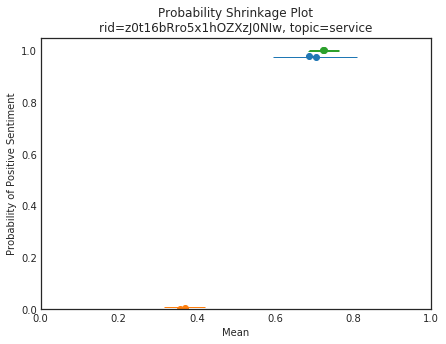

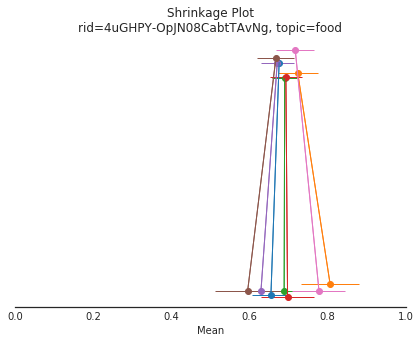

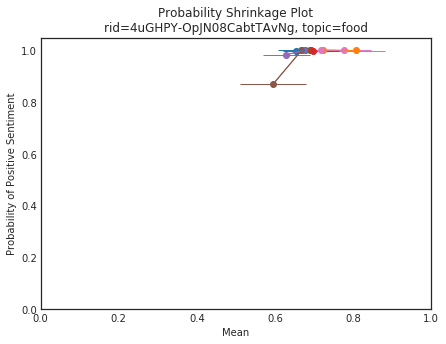

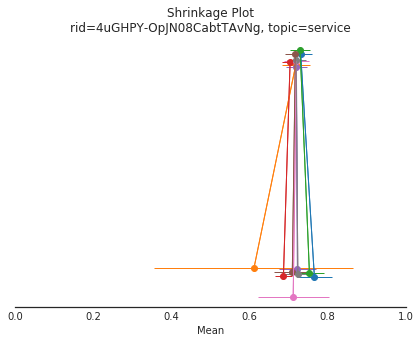

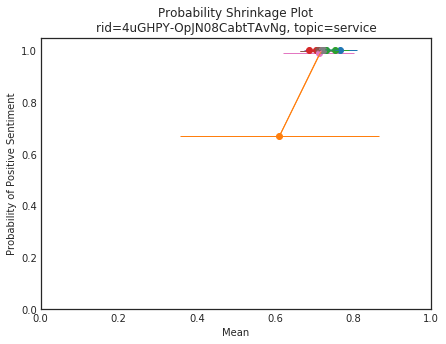

In [290]:
# shrinkage and prob shrinkage plots
thetas = summary(traces[0][rids[9]][0][100:])[-traces[0][rids[9]][1]:]['mean'].values
theta_vars = summary(traces[0][rids[9]][0][100:])[-traces[0][rids[9]][1]:]['sd'].values**2
means = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['mean'].values
mean_vars = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['var'].values
counts = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['count'].values

shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Shrinkage Plot\nrid=' + rids[9] + ', topic=food')
plt.xlabel('Mean')
plt.show()

prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Probability Shrinkage Plot\nrid=' + rids[9] + ', topic=food')
plt.xlabel('Mean')
plt.ylabel('Probability of Positive Sentiment')
plt.show()

thetas = summary(traces[1][rids[9]][0][100:])[-traces[1][rids[9]][1]:]['mean'].values
theta_vars = summary(traces[1][rids[9]][0][100:])[-traces[1][rids[9]][1]:]['sd'].values**2
means = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['mean'].values
mean_vars = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['var'].values
counts = rest10_df[(rest10_df['rid']==rids[9])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['count'].values

shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Shrinkage Plot\nrid=' + rids[9] + ', topic=service')
plt.xlabel('Mean')
plt.show()

prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Probability Shrinkage Plot\nrid=' + rids[9] + ', topic=service')
plt.xlabel('Mean')
plt.ylabel('Probability of Positive Sentiment')
plt.show()

thetas = summary(traces[0][rids[1]][0][100:])[-traces[0][rids[1]][1]:]['mean'].values
theta_vars = summary(traces[0][rids[1]][0][100:])[-traces[0][rids[1]][1]:]['sd'].values**2
means = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['mean'].values
mean_vars = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['var'].values
counts = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 0)&(rest10_df['count'] != 1)]['count'].values

shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Shrinkage Plot\nrid=' + rids[1] + ', topic=food')
plt.xlabel('Mean')
plt.show()

prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Probability Shrinkage Plot\nrid=' + rids[1] + ', topic=food')
plt.xlabel('Mean')
plt.ylabel('Probability of Positive Sentiment')
plt.show()

thetas = summary(traces[1][rids[1]][0][100:])[-traces[1][rids[1]][1]:]['mean'].values
theta_vars = summary(traces[1][rids[1]][0][100:])[-traces[1][rids[1]][1]:]['sd'].values**2
means = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['mean'].values
mean_vars = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['var'].values
counts = rest10_df[(rest10_df['rid']==rids[1])&(rest10_df['topic'] == 1)&(rest10_df['count'] != 1)]['count'].values

shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Shrinkage Plot\nrid=' + rids[1] + ', topic=service')
plt.xlabel('Mean')
plt.show()

prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts)
plt.title('Probability Shrinkage Plot\nrid=' + rids[1] + ', topic=service')
plt.xlabel('Mean')
plt.ylabel('Probability of Positive Sentiment')
plt.show()

The plots show us that when the standard error of a value in 'mean' is relatively high, the corresponding value for theta is closer to the mean sentiment across all reviewers of a given restaurant on a given topic (this is because the prior parameters for each mu were chosen using an empirical Bayes approach). The probability shrinkage plots show us that when the standard error of a value in 'mean' is relatively high, the classification probability becomes closer to the classification probabilites corresponding to the other reviewers of a given restaurant on a given topic (again, this is due to the use of an empirical Bayes approach when choosing the prior parameters for each mu). Modeling reviewer sentiment (using the empirical Bayes approach) is preferable since we get to 'borrow' information from other reviewers of a given restaurant on a given topic when we are uncertain about the sentiment of a particular reviewer as opposed to just taking the value in 'mean' and the classification probability at face value.

### Part C

In [291]:
# getting thetas and associated rids in separate dataframe for each topic
# ordering restaurants by mean of thetas for each topic
mean_thetas_food = []
mean_thetas_service = []
for topic in topics:
    for rid in rids:
        if topic==0:
            mean_thetas_food.append(np.mean(summary(traces[topic][rid][0][100:])[-traces[topic][rid][1]:]['mean'].values))
        elif topic==1:
            mean_thetas_service.append(np.mean(summary(traces[topic][rid][0][100:])[-traces[topic][rid][1]:]['mean'].values))
                
food_df = pd.DataFrame([rids, mean_thetas_food]).transpose()
food_df.columns = ['rid', 'Mean of Thetas']

service_df = pd.DataFrame([rids, mean_thetas_service]).transpose()
service_df.columns = ['rid', 'Mean of Thetas']

overall_df = pd.DataFrame([rids, (np.array(mean_thetas_service) + np.array(mean_thetas_food))/2]).transpose()
overall_df.columns = ['rid', 'Avg of Mean of Thetas for Food and Mean of Thetas for Service']

print('Restaurant rank order (food):')
print(food_df.sort_values('Mean of Thetas', ascending=False))
print()
print('Restaurant rank order (service):')
print(service_df.sort_values('Mean of Thetas', ascending=False))
print()
print('Restaurant rank order (overall):')
print(overall_df.sort_values('Avg of Mean of Thetas for Food and Mean of Thetas for Service', ascending=False))
print()

Restaurant rank order (food):
                      rid Mean of Thetas
8  tlex-h7TJ-b2X8cLCIfunQ       0.708678
1  4uGHPY-OpJN08CabtTAvNg       0.691355
9  z0t16bRro5x1hOZXzJ0NIw       0.626236
7  sY7OAhyojv3YI0EUUW_gUQ       0.613915
5  d9JI2Js8oGOeVQDr2q3KQw       0.596627
6  epMKlsA-OoZMNcXTMmWoMw       0.592397
3  LxE7D6uigL3vLaasPU7Ewg       0.588161
0  0LLaVEXjtW0aW0FzU9uRoA       0.587681
2  62EQGCWUVIRixQD_q72V0Q       0.586748
4  d8FP2gvMoeiiIa5mdn8jZg       0.516378

Restaurant rank order (service):
                      rid Mean of Thetas
1  4uGHPY-OpJN08CabtTAvNg       0.720148
8  tlex-h7TJ-b2X8cLCIfunQ       0.703165
2  62EQGCWUVIRixQD_q72V0Q       0.612144
6  epMKlsA-OoZMNcXTMmWoMw       0.600228
9  z0t16bRro5x1hOZXzJ0NIw       0.593423
5  d9JI2Js8oGOeVQDr2q3KQw       0.591596
0  0LLaVEXjtW0aW0FzU9uRoA       0.570033
3  LxE7D6uigL3vLaasPU7Ewg       0.563309
4  d8FP2gvMoeiiIa5mdn8jZg       0.521817
7  sY7OAhyojv3YI0EUUW_gUQ       0.430305

Restaurant rank order (overall):


For each topic, I ranked the restaurants based on the means of the associated thetas. To get an overall ranking of the restaurants, I used the averages of those means. One weakness of the topic rankings is that the means of the thetas they are derived from are based on a fairly small number of reviews in some cases. The rankings would be more believable if all of the means of the thetas were based off of more reviews. Another weakness of the topic rankings is that using means of the thetas involves applying an equal weighting to each theta when computing those means even though some thetas are based off of more sentences than others. A weakness of the overall ranking is that the averages that produce them are computed by applying equal weighting to the mean of thetas for each topic even though the numbers of reviews that those topic means are based on are not necessarily the same. Furthermore, the weaknesses associated with the means of the thetas that produced the topic rankings bleed through to the overall rankings.